<a href="https://colab.research.google.com/github/thantzintun232/AI-for-Indoor-Air-Quality-Forecasting/blob/main/NTLL_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
full_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation/cleaned_air_quality.csv')
full_df.head()

,installation_name,installation_site,timestamp,pm2_5,temp_aq,humidity_aq,voc_aq,co2_gas,source_file,date,weekday,is_weekend
0,External - front of James Graham,Headingley Campus,2025-03-01 00:04:58,24.09,3.039062,76.490273,231.0,688.0,2025-03-01.xlsx,2025-03-01,Saturday,True
1,External - front of James Graham,Headingley Campus,2025-03-01 00:09:58,24.19,2.796875,76.534142,236.0,713.0,2025-03-01.xlsx,2025-03-01,Saturday,True
2,External - front of James Graham,Headingley Campus,2025-03-01 00:14:58,27.03,2.507812,77.245590,244.0,723.0,2025-03-01.xlsx,2025-03-01,Saturday,True
3,External - front of James Graham,Headingley Campus,2025-03-01 00:19:58,24.36,2.273438,80.606392,228.0,633.0,2025-03-01.xlsx,2025-03-01,Saturday,True
4,External - front of James Graham,Headingley Campus,2025-03-01 00:24:58,25.00,2.281250,79.978867,223.0,660.0,2025-03-01.xlsx,2025-03-01,Saturday,True


In [ ]:
df_co2 = full_df[['timestamp', 'installation_name', 'co2_gas']].copy()
df_co2['timestamp'] = pd.to_datetime(df_co2['timestamp'], errors='coerce')
df_co2 = df_co2.sort_values(['installation_name', 'timestamp']).reset_index(drop=True)

print(df_co2.head())
print("Sensors found:", df_co2['installation_name'].nunique())

            timestamp                installation_name  co2_gas
0 2025-03-01 00:00:01  External - Rear of James Graham    569.0
1 2025-03-01 01:00:01  External - Rear of James Graham    564.0
2 2025-03-01 02:00:01  External - Rear of James Graham    518.0
3 2025-03-01 09:00:15  External - Rear of James Graham    614.0
4 2025-03-01 10:01:51  External - Rear of James Graham    581.0
Sensors found: 10


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

WINDOW = 10

client_ids = df_co2['installation_name'].unique().tolist()

train_arrays = []
raw_client_splits = {}

for cid in client_ids:
    s = df_co2[df_co2['installation_name'] == cid]['co2_gas'].values.astype('float32').reshape(-1,1)
    cut = int(len(s)*0.8)
    raw_client_splits[cid] = {'train': s[:cut], 'test': s[cut:]}
    train_arrays.append(s[:cut])

scaler = MinMaxScaler()
scaler.fit(np.vstack(train_arrays))

def make_sequences(arr, window=WINDOW):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    X = np.asarray(X).reshape(-1, window, 1)
    y = np.asarray(y).reshape(-1, 1)
    return X, y

clients = {}
for cid in client_ids:
    tr = scaler.transform(raw_client_splits[cid]['train'])
    te = scaler.transform(raw_client_splits[cid]['test'])

    X_tr_all, y_tr_all = make_sequences(tr, WINDOW)
    X_te,     y_te     = make_sequences(te, WINDOW)

    n_val = max(1, int(0.1 * len(X_tr_all)))
    clients[cid] = {
        'X_tr': X_tr_all[:-n_val], 'y_tr': y_tr_all[:-n_val],
        'X_va': X_tr_all[-n_val:], 'y_va': y_tr_all[-n_val:],
        'X_te': X_te, 'y_te': y_te
    }

len(client_ids), list(clients.keys())


(10,
 ['External - Rear of James Graham',
  'External - front of James Graham',
  'JG107',
  'JG115',
  'JG119',
  'JG202',
  'JG204',
  'JG207',
  'JG217',
  'JG221'])

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

UNITS = 64
LR = 1e-3
LOCAL_EPOCHS = 3
BATCH = 64
ROUNDS = 15
CLIENT_FRACTION = 0.6

def build_model():
    m = tf.keras.Sequential([
        tf.keras.layers.LSTM(UNITS, input_shape=(clients[next(iter(clients))]['X_tr'].shape[1], 1)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
    return m

def get_w(m): return m.get_weights()
def set_w(m, w): m.set_weights(w)

def weighted_avg(weights_list, sizes):
    total = np.sum(sizes)
    new = []
    for layer in zip(*weights_list):
        acc = np.zeros_like(layer[0])
        for w, n in zip(layer, sizes):
            acc += (n/total) * w
        new.append(acc)
    return new

round_train_losses, round_val_losses = [], []

global_model   = build_model()
global_weights = get_w(global_model)
client_ids     = list(clients.keys())

for r in range(1, ROUNDS + 1):
    k = max(1, int(len(client_ids) * CLIENT_FRACTION))
    chosen = np.random.choice(client_ids, size=k, replace=False)

    local_ws, local_ns = [], []
    pl_train, pl_val, pl_sizes = [], [], []

    for cid in chosen:
        d = clients[cid]
        m = build_model()
        set_w(m, global_weights)

        hist = m.fit(
            d['X_tr'], d['y_tr'],
            validation_data=(d['X_va'], d['y_va']),
            epochs=LOCAL_EPOCHS, batch_size=BATCH, verbose=0
        )

        local_ws.append(get_w(m))
        n_train = len(d['X_tr'])
        local_ns.append(n_train)

        pl_train.append(hist.history['loss'][-1])
        pl_val.append(hist.history['val_loss'][-1])
        pl_sizes.append(n_train)

    global_weights = weighted_avg(local_ws, local_ns)
    set_w(global_model, global_weights)

    total = np.sum(pl_sizes)
    w_train = float(np.sum([l*(n/total) for l, n in zip(pl_train, pl_sizes)]))
    w_val   = float(np.sum([l*(n/total) for l, n in zip(pl_val,   pl_sizes)]))

    round_train_losses.append(w_train)
    round_val_losses.append(w_val)

    print(f"Round {r}/{ROUNDS} — clients {len(chosen)} | train_loss={w_train:.5f} | val_loss={w_val:.5f}")

y_true_all, y_pred_all = [], []
for cid in client_ids:
    X_te = clients[cid]['X_te']
    y_te = clients[cid]['y_te']
    if len(X_te) == 0:
        continue
    pred = global_model.predict(X_te, verbose=0).reshape(-1)
    true = y_te.reshape(-1)
    y_true_all.append(true)
    y_pred_all.append(pred)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mae  = mean_absolute_error(y_true_all, y_pred_all)
rmse = float(np.sqrt(np.mean((y_true_all - y_pred_all)**2)))
mape = float(np.mean(np.abs((y_true_all - y_pred_all)/np.clip(np.abs(y_true_all), 1e-8, None)))*100)
r2   = r2_score(y_true_all, y_pred_all)

print("\nGlobal Test Metrics (FedAvg, LSTM):")
print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²  :", r2)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Round 1/15 — clients 6 | train_loss=0.00368 | val_loss=0.00341
Round 2/15 — clients 6 | train_loss=0.00353 | val_loss=0.00336
Round 3/15 — clients 6 | train_loss=0.00354 | val_loss=0.00434
Round 4/15 — clients 6 | train_loss=0.00460 | val_loss=0.00426
Round 5/15 — clients 6 | train_loss=0.00312 | val_loss=0.00253
Round 6/15 — clients 6 | train_loss=0.00348 | val_loss=0.00432
Round 7/15 — clients 6 | train_loss=0.00452 | val_loss=0.00394
Round 8/15 — clients 6 | train_loss=0.00278 | val_loss=0.00319
Round 9/15 — clients 6 | train_loss=0.00317 | val_loss=0.00332
Round 10/15 — clients 6 | train_loss=0.00297 | val_loss=0.00326
Round 11/15 — clients 6 | train_loss=0.00288 | val_loss=0.00395
Round 12/15 — clients 6 | train_loss=0.00326 | val_loss=0.00340
Round 13/15 — clients 6 | train_loss=0.00396 | val_loss=0.00360
Round 14/15 — clients 6 | train_loss=0.00383 | val_loss=0.00364
Round 15/15 — clients 6 | train_loss=0.00290 | val_loss=0.00248

Global Test Metrics (FedAvg, LSTM):
MAE : 0.0408

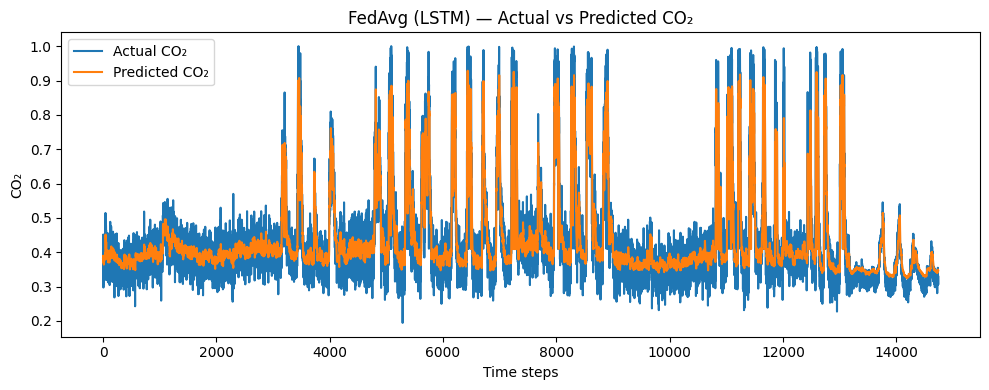

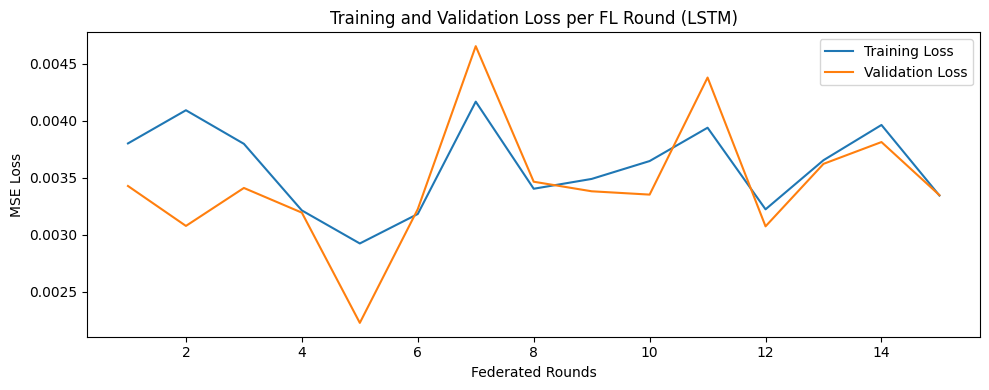

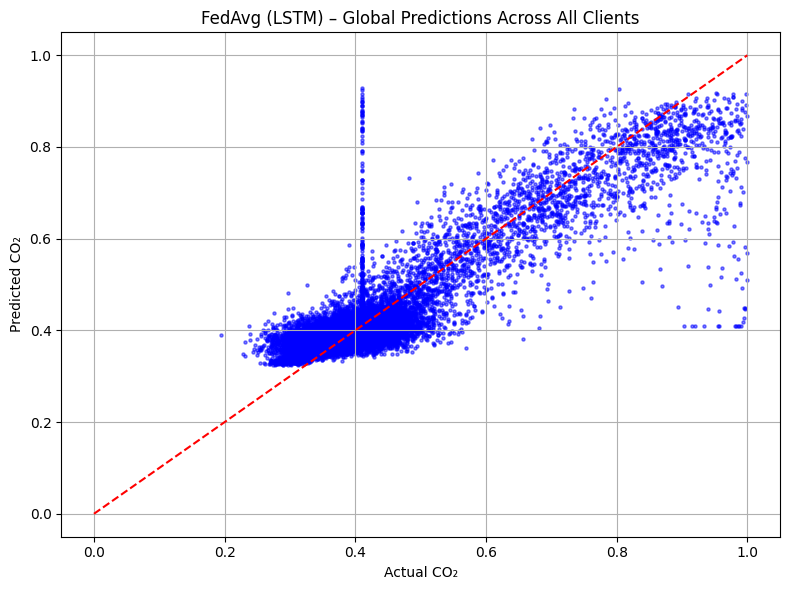

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y_true_all, label="Actual CO₂")
plt.plot(y_pred_all, label="Predicted CO₂")
plt.title("FedAvg (LSTM) — Actual vs Predicted CO₂")
plt.xlabel("Time steps")
plt.ylabel("CO₂")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1, len(round_train_losses)+1), round_train_losses, label="Training Loss")
plt.plot(range(1, len(round_val_losses)+1),   round_val_losses,   label="Validation Loss")
plt.title("Training and Validation Loss per FL Round (LSTM)")
plt.xlabel("Federated Rounds")
plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_true_all, y_pred_all, s=5, alpha=0.5, c='blue')
plt.plot([0,1],[0,1],'--', color='red')
plt.xlabel("Actual CO₂")
plt.ylabel("Predicted CO₂")
plt.title(f"FedAvg ({MODEL.upper()}) – Global Predictions Across All Clients")
plt.grid(True)
plt.tight_layout()
plt.show()


# GRU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Round 1/15 — clients 6 | train_loss=0.00396 | val_loss=0.00478
Round 2/15 — clients 6 | train_loss=0.00409 | val_loss=0.00385
Round 3/15 — clients 6 | train_loss=0.00271 | val_loss=0.00303
Round 4/15 — clients 6 | train_loss=0.00380 | val_loss=0.00359
Round 5/15 — clients 6 | train_loss=0.00354 | val_loss=0.00376
Round 6/15 — clients 6 | train_loss=0.00343 | val_loss=0.00341
Round 7/15 — clients 6 | train_loss=0.00377 | val_loss=0.00354
Round 8/15 — clients 6 | train_loss=0.00447 | val_loss=0.00496
Round 9/15 — clients 6 | train_loss=0.00488 | val_loss=0.00500
Round 10/15 — clients 6 | train_loss=0.00404 | val_loss=0.00387
Round 11/15 — clients 6 | train_loss=0.00405 | val_loss=0.00468
Round 12/15 — clients 6 | train_loss=0.00293 | val_loss=0.00341
Round 13/15 — clients 6 | train_loss=0.00256 | val_loss=0.00288
Round 14/15 — clients 6 | train_loss=0.00480 | val_loss=0.00513
Round 15/15 — clients 6 | train_loss=0.00339 | val_loss=0.00405

Global Test Metrics (FedAvg, GRU):
MAE : 0.04018

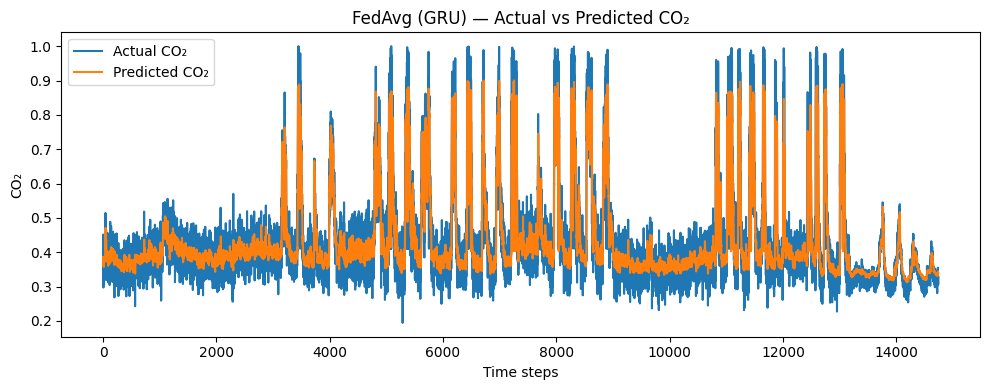

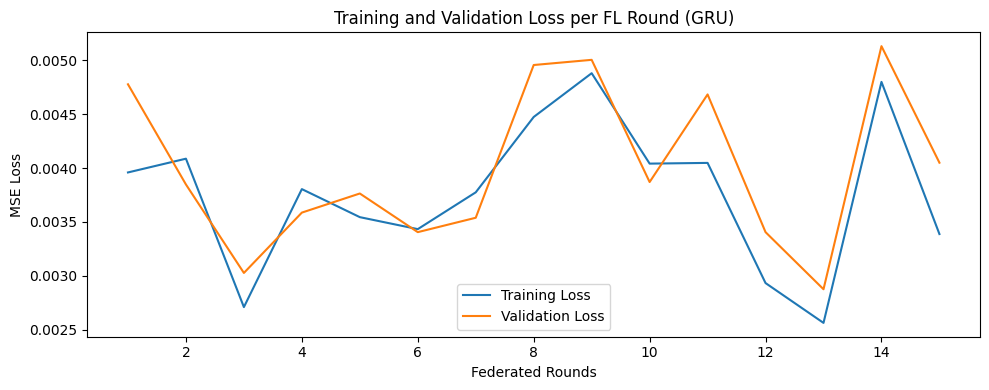

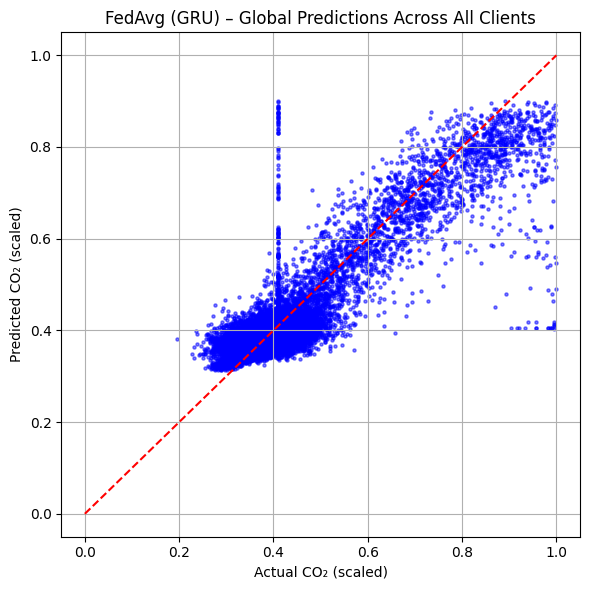

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

UNITS = 64
LR = 1e-3
LOCAL_EPOCHS = 3
BATCH = 64
ROUNDS = 15
CLIENT_FRACTION = 0.6

def build_model():
    m = tf.keras.Sequential([
        tf.keras.layers.GRU(UNITS, input_shape=(clients[next(iter(clients))]['X_tr'].shape[1], 1)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="mse")
    return m

def get_w(m): return m.get_weights()
def set_w(m, w): m.set_weights(w)

def weighted_avg(weights_list, sizes):
    total = np.sum(sizes)
    new = []
    for layer in zip(*weights_list):
        acc = np.zeros_like(layer[0])
        for w, n in zip(layer, sizes):
            acc += (n/total) * w
        new.append(acc)
    return new

round_train_losses, round_val_losses = [], []

global_model   = build_model()
global_weights = get_w(global_model)
client_ids     = list(clients.keys())

for r in range(1, ROUNDS + 1):
    k = max(1, int(len(client_ids) * CLIENT_FRACTION))
    chosen = np.random.choice(client_ids, size=k, replace=False)

    local_ws, local_ns = [], []
    pl_train, pl_val, pl_sizes = [], [], []

    for cid in chosen:
        d = clients[cid]
        m = build_model()
        set_w(m, global_weights)

        hist = m.fit(
            d['X_tr'], d['y_tr'],
            validation_data=(d['X_va'], d['y_va']),
            epochs=LOCAL_EPOCHS, batch_size=BATCH, verbose=0
        )

        local_ws.append(get_w(m))
        n_train = len(d['X_tr'])
        local_ns.append(n_train)

        pl_train.append(hist.history['loss'][-1])
        pl_val.append(hist.history['val_loss'][-1])
        pl_sizes.append(n_train)

    global_weights = weighted_avg(local_ws, local_ns)
    set_w(global_model, global_weights)

    total = np.sum(pl_sizes)
    w_train = float(np.sum([l*(n/total) for l, n in zip(pl_train, pl_sizes)]))
    w_val   = float(np.sum([l*(n/total) for l, n in zip(pl_val,   pl_sizes)]))

    round_train_losses.append(w_train)
    round_val_losses.append(w_val)

    print(f"Round {r}/{ROUNDS} — clients {len(chosen)} | train_loss={w_train:.5f} | val_loss={w_val:.5f}")

y_true_all, y_pred_all = [], []
for cid in client_ids:
    X_te = clients[cid]['X_te']
    y_te = clients[cid]['y_te']
    if len(X_te) == 0:
        continue
    pred = global_model.predict(X_te, verbose=0).reshape(-1)
    true = y_te.reshape(-1)
    y_true_all.append(true)
    y_pred_all.append(pred)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

mae  = mean_absolute_error(y_true_all, y_pred_all)
rmse = float(np.sqrt(np.mean((y_true_all - y_pred_all)**2)))
mape = float(np.mean(np.abs((y_true_all - y_pred_all)/np.clip(np.abs(y_true_all), 1e-8, None)))*100)
r2   = r2_score(y_true_all, y_pred_all)

print("\nGlobal Test Metrics (FedAvg, GRU):")
print("MAE :", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R²  :", r2)

plt.figure(figsize=(10,4))
plt.plot(y_true_all, label="Actual CO₂")
plt.plot(y_pred_all, label="Predicted CO₂")
plt.title("FedAvg (GRU) — Actual vs Predicted CO₂")
plt.xlabel("Time steps")
plt.ylabel("CO₂")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1, len(round_train_losses)+1), round_train_losses, label="Training Loss")
plt.plot(range(1, len(round_val_losses)+1),   round_val_losses,   label="Validation Loss")
plt.title("Training and Validation Loss per FL Round (GRU)")
plt.xlabel("Federated Rounds")
plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

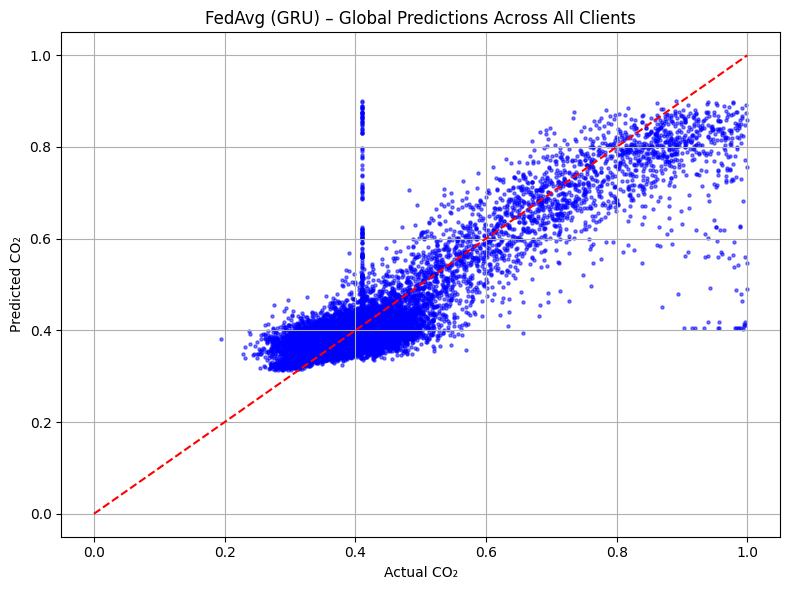

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_true_all, y_pred_all, s=5, alpha=0.5, c='blue')
plt.plot([0,1],[0,1],'--', color='red')
plt.xlabel("Actual CO₂")
plt.ylabel("Predicted CO₂")
plt.title("FedAvg (GRU) – Global Predictions Across All Clients")
plt.grid(True)
plt.tight_layout()
plt.show()